In [ ]:
OAUTH_TOKEN='' #OAuth API token that you can find in spotify api
playlist_ids = ['37i9dQZF1DWX9u2doQ8Q2L','7lGmJcLihxa3bVawvCsCpW', '37i9dQZF1DX3YMp9n8fkNx', 
                '37i9dQZF1DX9yFwLezFDuE', '6qd48xm5P7JXCxSdIQe4Ur', '1TdTz1c9jp0fB4s4ZRgtV3', 
                '3UVNqcek0Hg8ne1ijJn9kc', '1tpaq0ljvCNcTuHy1yjyTY', '7KFoK4LJ23EncELJwYmTDG',
               '6ZlFKcTzJVslgjudScTX4G', '32FBABAt8zLNUkoLmuC53l', '32FBABAt8zLNUkoLmuC53l',
                '4xdxJkAF39xvfqxdiAkKVK','6g7w28tPfDtmuMGSuQdkoJ', '17jpHzURZPYRY91mMsNWX4',
                '3crEbeyihVkc467poiIV03',
               ]


In [ ]:
import requests
import json

req_headers = {
    'Authorization': f'Bearer {OAUTH_TOKEN}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

url_prefix = 'https://api.spotify.com/v1/playlists/'
url_suffix = '/tracks'

result = requests.get(url_prefix+playlist_ids[0]+url_suffix, headers=req_headers).content

In [ ]:
json_data = json.loads(result)

In [ ]:
artists_lst = []
songs_lst = []
full_lst = []
for playlist_id in playlist_ids:
    url = url_prefix+playlist_id+url_suffix
    res = requests.get(url, headers=req_headers).content
    json_data = json.loads(res)
    for item in json_data['items']:
        artists = item['track']['artists']
        song = item['track']['name']
        if len(artists) > 1:
            artists_name = []
            full_elems = []
            for artist in artists:
                artists_name.append(artist['name'])
                full_elems.append(artist['name'])
            artists_lst.append(artists_name)
            artists_lst.sort()
            full_elems.sort()
            songs_lst.append(song)
            full_elems.append(song)
            full_lst.append(full_elems)

In [ ]:
#remove any duplicates
unique_data = list(set(tuple(x) for x in full_lst))
unique_data=unique_data[::-1]

In [ ]:
lst = ['a','b','c']
lst[:-1]

['a', 'b']

In [ ]:
unique_data = [x[:-1] for x in full_lst]

In [ ]:
artist_pairs = []
for row in full_lst:
    for i in range(len(row)-2):
        for j in range(i+1,len(row)-1):
            artist_pairs.append((row[i], row[j]))
print(len(artist_pairs))
print(artist_pairs[3])

672
('AAAMYYY', 'Yaffle')


In [ ]:
import pandas as pd

adj_df = pd.DataFrame(artist_pairs, columns=['Artist1', 'Artist2'])

In [ ]:
adj_df.tail()

,Artist1,Artist2
667,Eurielle,Quality Control
668,Migos,Quality Control
669,Kodak Black,Offset
670,Trippie Redd,XXXTENTACION
671,21 Savage,Post Malone


In [ ]:
adj_df['weight'] = 1
adj_df = adj_df.groupby(['Artist1', 'Artist2']).weight.sum().reset_index()
adj_df = adj_df.drop_duplicates()

In [ ]:
#add non-connected artists
non_collaborating_artists = {(artist1, artist2) for artist1 in adj_df['Artist1'].values for artist2 in adj_df['Artist2'].values if artist1!=artist2}
collaborating_artists = {(adj_df['Artist1'].values[i], adj_df['Artist2'].values[i]) for i in range(len(adj_df))}

In [ ]:
lst_non = [] 
for artist_pair in non_collaborating_artists:
    if artist_pair[1] < artist_pair[0]:
        lst_non.append((artist_pair[1], artist_pair[0]))
    else:
        lst_non.append((artist_pair[0], artist_pair[1]))
non_collaborating_artists = set(lst_non)

In [ ]:
non_collaborating_artists = non_collaborating_artists - collaborating_artists

In [ ]:
len(non_collaborating_artists)

112741

In [ ]:
len(collaborating_artists)

607

In [ ]:
import random

non_collaborating_artists  = list(non_collaborating_artists)
random.shuffle(non_collaborating_artists)
non_collaborating_artists = random.sample(non_collaborating_artists, len(collaborating_artists))

In [ ]:
neg_adj_df = pd.DataFrame(non_collaborating_artists, columns=['Artist1', 'Artist2'])
neg_adj_df['weight'] = 0

adj_df = adj_df.append(neg_adj_df, ignore_index=True)
adj_df = adj_df.sample(frac=1).reset_index(drop=True)
adj_df['isConnected'] = adj_df.apply(lambda row: row['weight'] > 0, axis=1)

In [ ]:
adj_df.to_csv('spotify_full.csv', index=False)

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

adj_df = adj_df[adj_df['isConnected']==True]
G = nx.Graph()
for i, row in adj_df.iterrows():
    G.add_edge(row['Artist1'], row['Artist2'], weight=row['weight'])

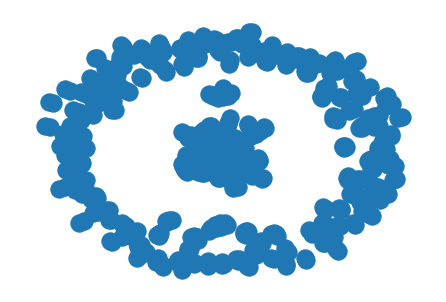

In [ ]:
nx.draw(G)

In [ ]:
nx.write_gexf(G, "spotify.gexf")